### Survival model 

Here we want to build propre statistic model to access impact on survival accounting for covariates.

First we want to validate a simple model on long vs short format to confirm that there is no time dependencies as the KM curve didn't overlap. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

import warnings 
import pytz
import pymc as pm
from pytensor import tensor as T
import arviz as az
from pymc.distributions.timeseries import GaussianRandomWalk

from cubee.configs.filepath import formatted_datapath, raw_datapath

warnings.filterwarnings("ignore")

In [2]:
LOWER_PRIOR = 1.10
HIGH_PRIOR = 1.3
interval_length = 90
ROLLING_CUBEE_MONTH = 3
n_samples = 800
n_tune = 1200

### 0. Load data

In [3]:
data = pd.read_csv(formatted_datapath)
data = data.dropna(subset="queen_id").reset_index(drop=True)
data['death'] = data["state"].apply(lambda x: True if x < 1 else False)
data.head()

,time1,time2,state,hive_age,cubee,fob,fobr,foh,varroa,queen_age,queen_state,queen_cubee,queen_id,brood_pattern,stings,hid,hive_interacted,death
0,29,59,0,401,0,1.587713,1.000000,2.000000,1.311579,15.0,True,NaN,55971_queen_0,1.479610,2.0,55971,14,True
1,29,59,1,383,0,4.547150,3.031433,1.319508,NaN,14.0,False,NaN,56410_queen_0,4.573051,0.0,56410,20,False
2,59,88,1,414,0,10.000000,5.000000,2.828427,NaN,45.0,False,NaN,56410_queen_0,4.472136,0.0,56410,19,False
3,88,118,1,453,0,11.676289,6.893791,4.733388,0.000000,84.0,False,NaN,56410_queen_0,4.661359,0.0,56410,21,False
4,118,148,1,484,0,11.142714,3.073467,4.878825,0.000000,98.0,True,NaN,56410_queen_0,2.734851,0.0,56410,22,False


### Quick look at the short format

In [4]:
cubee_dose = data.groupby("queen_id")['cubee'].sum().reset_index()
states = data.groupby("queen_id")[['queen_state','queen_age']].max().reset_index()
sliders = data.groupby("queen_id")[['fob','fobr','varroa']].mean().reset_index()
short = pd.merge(states,cubee_dose,on="queen_id",how="left")
short = pd.merge(short,sliders, on='queen_id',how='left')
short['cubee'] = short['cubee'].fillna(0)
short['fob'] = short['fob'].fillna(0)
short['varroa'] = short['varroa'].fillna(0)

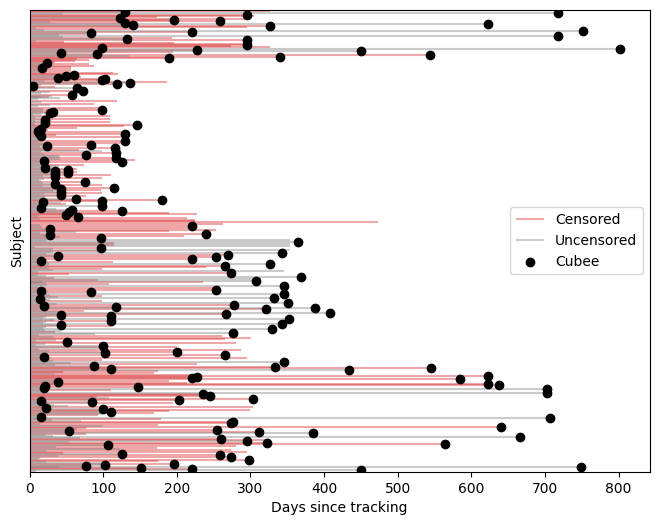

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
short['cubee_bool'] = short['cubee'] > 1
short = short.sort_values(["queen_age"])
ax.hlines(
    short[short.queen_state==0].index, 0, short[short.queen_state==0].queen_age, color="C3", label="Censored",alpha=0.4
)

ax.hlines(
    short[short.queen_state==1].index, 0, short[short.queen_state==1].queen_age, color="C7", label="Uncensored",alpha=0.4
)

ax.scatter(
    short[short.cubee.values >0].queen_age,
    short[short.cubee.values > 0].index,
    color="k",
    zorder=4,
    label="Cubee",
)

ax.set_xlim(left=0)
ax.set_xlabel("Days since tracking")
ax.set_yticks([])
ax.set_ylabel("Subject")

ax.set_ylim(-0.25, len(short) + 0.25)

ax.legend(loc="center right");

### 1. Create a simple Bayesian CoxPH model

In [6]:

interval_bounds = np.arange(0, short.queen_age.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

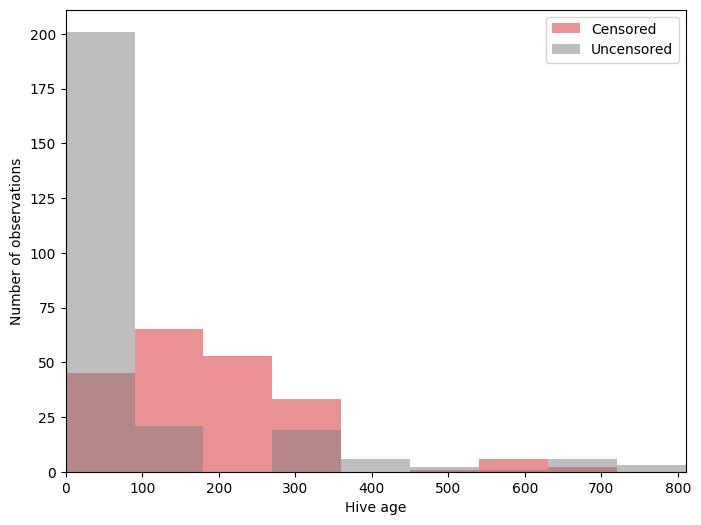

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(
    short[short.queen_state == 0].queen_age.values,
    bins=interval_bounds,
    lw=0,
    color="C3",
    alpha=0.5,
    label="Censored",
)

ax.hist(
    short[short.queen_state == 1].queen_age.values,
    bins=interval_bounds,
    lw=0,
    color="C7",
    alpha=0.5,
    label="Uncensored",
)

ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel("Hive age")

# ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel("Number of observations")

ax.legend();

In [8]:
last_period = np.floor((short.queen_age - 0.01) / interval_length).astype(int)
n_hives = len(short)
death = np.zeros((n_hives, n_intervals))
death[short.index, last_period] = short.queen_state.fillna(True)
exposure = np.greater_equal.outer(short.queen_age.to_numpy(), interval_bounds[:-1]) * interval_length
exposure[short.index, last_period] = short.queen_age - interval_bounds[last_period]
exposure = np.absolute(exposure)

In [9]:
coords = {"intervals": intervals}

x = short['cubee_bool']
xfob = short['fob']
xvarroa = short['varroa']

with pm.Model(coords=coords) as model:
    lambda0 = pm.Gamma("lambda0", LOWER_PRIOR, HIGH_PRIOR, dims="intervals")
    # lambda1 = pm.Gamma("lambda1", 0.5, 1.5, dims="intervals")
    # lambda2 = pm.Gamma("lambda2", 0.5, 1.0, dims="intervals")

    beta = pm.Normal("beta", 0, sigma=2)

    lambda_ = pm.Deterministic("lambda_", T.outer(T.exp(beta * x), lambda0))
    # lambda_1 = pm.Deterministic("lambda_1", T.outer(T.exp(beta * xfob), lambda1))
    # lambda_2 = pm.Deterministic("lambda_2", T.outer(T.exp(beta * xvarroa), lambda2))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

In [10]:

with model:
    idata = pm.sample(
        n_samples,
        tune=n_tune,
        target_accept=0.99,
        random_seed=8,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Output()

Sampling 4 chains for 1_200 tune and 800 draw iterations (4_800 + 3_200 draws total) took 20 seconds.


In [11]:
base_hazard = idata.posterior["lambda0"] #+ idata.posterior["lambda0"]
met_hazard = idata.posterior["lambda0"] * np.exp(idata.posterior["beta"]) #+ idata.posterior["lambda1"] * np.exp(idata.posterior["beta"])

### Time varying

Group cubee on 3 months span 

In [12]:
data['cubee'] = data.groupby("hid")['cubee'].rolling(ROLLING_CUBEE_MONTH).sum().reset_index()['cubee']
data['fob'] = data.groupby("hid")['fob'].rolling(ROLLING_CUBEE_MONTH).mean().reset_index()['fob']
data['varroa'] = data.groupby("hid")['varroa'].rolling(ROLLING_CUBEE_MONTH).mean().reset_index()['varroa']
data['cubee'] = data['cubee'].fillna(0)
data.fob = data.fob.fillna(0.0)
data.varroa = data.varroa.fillna(0.0)

In [13]:
time_varying_interval_bounds = np.arange(0, data.queen_age.max() + interval_length + 1, interval_length)
n_intervals = time_varying_interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [14]:
last_period = np.floor((data.queen_age - 0.01) / interval_length).astype(int)
n_hives = len(data)
death = np.zeros((n_hives, n_intervals))
death[data.index, last_period] = data.queen_state.fillna(True)
exposure = np.greater_equal.outer(data.queen_age.to_numpy(), time_varying_interval_bounds[:-1]) * interval_length
exposure[data.index, last_period] = data.queen_age - time_varying_interval_bounds[last_period]
exposure = np.absolute(exposure)

In [15]:
coords = {"intervals": intervals}

with pm.Model(coords=coords) as time_varying_model:
    lambda0 = pm.Gamma("lambda0", LOWER_PRIOR, HIGH_PRIOR, dims="intervals")
    # lambda1 = pm.Gamma("lambda1", 0.5, 1.5, dims="intervals")
    # lambda2 = pm.Gamma("lambda2", 0.5, 1.0, dims="intervals")
    beta = GaussianRandomWalk("beta", init_dist=pm.Normal.dist(), sigma=2.0, dims="intervals")

    lambda_ = pm.Deterministic("h", lambda0 * T.exp(T.outer(T.constant(data.cubee), beta)))
    # lambda_2 = pm.Deterministic("h2", lambda1 * T.exp(T.outer(T.constant(data.fob), beta)))
    # lambda_3 = pm.Deterministic("h3", lambda2 * T.exp(T.outer(T.constant(data.varroa), beta)))
    mu = pm.Deterministic("mu", exposure * lambda_)

    obs = pm.Poisson("obs", mu, observed=death)

In [16]:
with time_varying_model:
    time_varying_idata = pm.sample(
        n_samples,
        tune=n_tune,
        return_inferencedata=True,
        target_accept=0.99,
        random_seed=8,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Output()

Sampling 4 chains for 1_200 tune and 800 draw iterations (4_800 + 3_200 draws total) took 154 seconds.


In [17]:
gv = pm.model_graph.model_to_graphviz(time_varying_model)
gv.format = 'png'
gv.render(filename='queen_model')


'queen_model.png'

In [18]:
tv_base_hazard = time_varying_idata.posterior["lambda0"] #+ time_varying_idata.posterior["lambda1"] #+ time_varying_idata.posterior["lambda2"]
tv_met_hazard = (time_varying_idata.posterior["lambda0"] * np.exp(
    time_varying_idata.posterior["beta"]
)) 

# + (time_varying_idata.posterior["lambda1"] * np.exp(
#     time_varying_idata.posterior["beta"]
# )) + (time_varying_idata.posterior["lambda2"] * np.exp(
#     time_varying_idata.posterior["beta"]
# ))

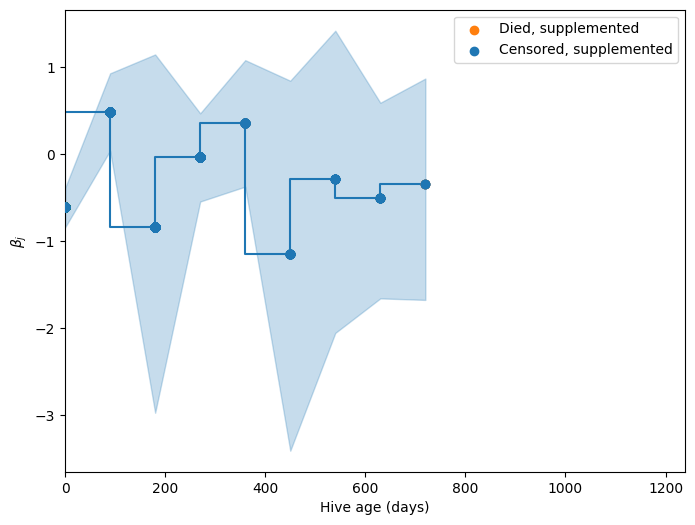

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

beta_eti = time_varying_idata.posterior["beta"].quantile((0.025, 0.975), dim=("chain", "draw"))
beta_eti_low = beta_eti.sel(quantile=0.025)
beta_eti_high = beta_eti.sel(quantile=0.975)

ax.fill_between(time_varying_interval_bounds[:-1], beta_eti_low, beta_eti_high, color="C0", alpha=0.25)

beta_hat = time_varying_idata.posterior["beta"].mean(("chain", "draw"))

ax.step(time_varying_interval_bounds[:-1], beta_hat, color="C0")

ax.scatter(
    time_varying_interval_bounds[last_period[(data.queen_state.values == 1) & (data.cubee > 0)]],
    beta_hat.isel(intervals=last_period[(data.queen_state.values == 1) & (data.cubee > 0)]),
    color="C1",
    zorder=10,
    label="Died, supplemented",
)

ax.scatter(
    time_varying_interval_bounds[last_period[(data.queen_state.values == 0) & (data.cubee >= 0)]],
    beta_hat.isel(intervals=last_period[(data.queen_state.values == 0) & (data.cubee >= 0)]),
    color="C0",
    zorder=10,
    label="Censored, supplemented",
)

ax.set_xlim(0, data.hive_age.max())
ax.set_xlabel("Hive age (days)")
ax.set_ylabel(r"$\beta_j$")
ax.legend();

In [20]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("chain", "draw"))

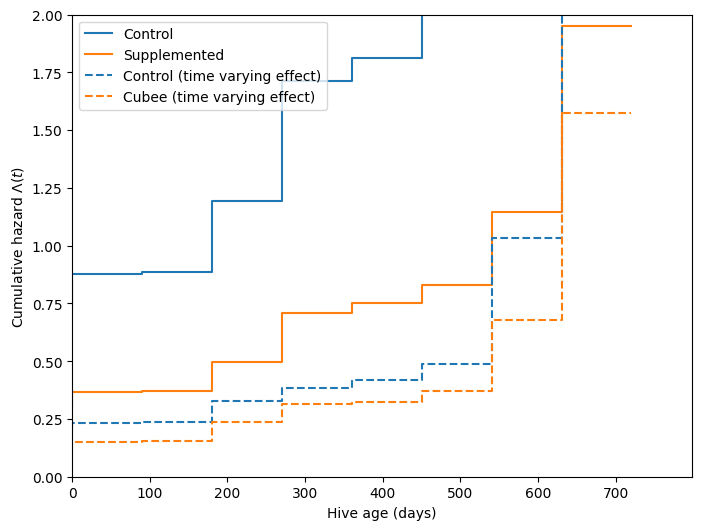

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.step(
    interval_bounds[:-1],
    cum_hazard(base_hazard.mean(("chain", "draw"))),
    color="C0",
    label="Control",
)

ax.step(
    interval_bounds[:-1],
    cum_hazard(met_hazard.mean(("chain", "draw"))),
    color="C1",
    label="Supplemented",
)

ax.step(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_base_hazard.mean(("chain", "draw"))),
    color="C0",
    linestyle="--",
    label="Control (time varying effect)",
)

ax.step(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_met_hazard.mean(dim=("chain", "draw"))),
    color="C1",
    linestyle="--",
    label="Cubee (time varying effect)",
)

ax.set_xlim(0, short.queen_age.max() - 4)
ax.set_xlabel("Hive age (days)")
ax.set_ylim(0, 2)
ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
ax.legend(loc=2);

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>,
       <Axes: title={'center': 'beta\n3'}>], dtype=object)

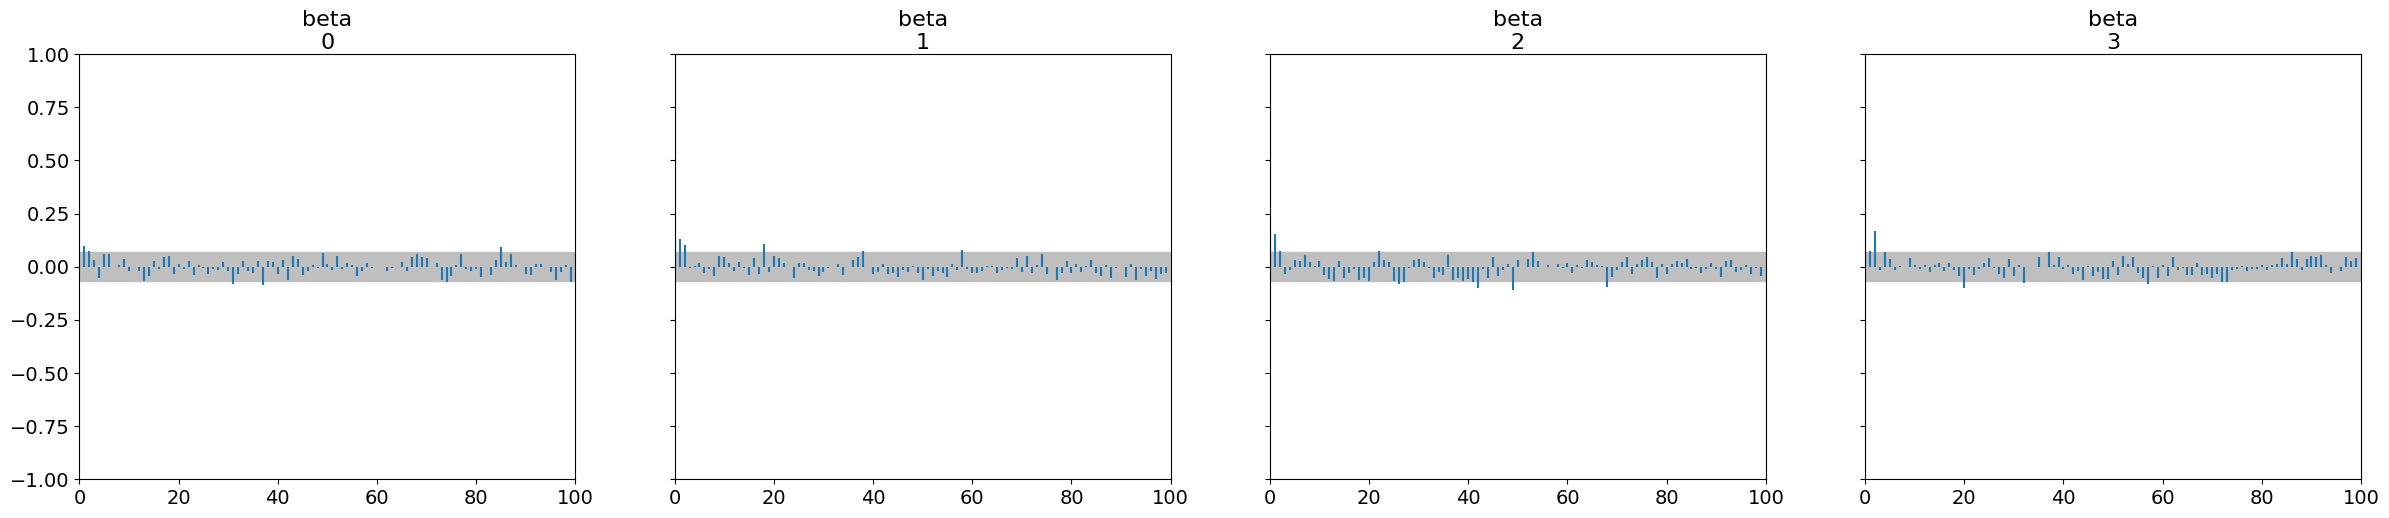

In [22]:
az.plot_autocorr(idata, var_names=["beta"])

<Axes: title={'center': 'beta'}>

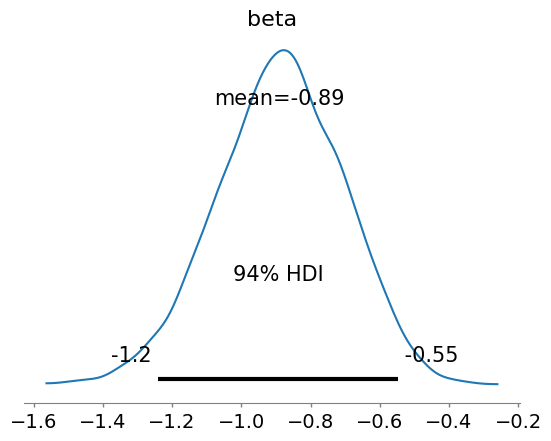

In [23]:
az.plot_posterior(idata, var_names=["beta"])

array([[<Axes: title={'center': 'beta\n0, 0'}>,
        <Axes: title={'center': 'beta\n0, 1'}>,
        <Axes: title={'center': 'beta\n0, 2'}>,
        <Axes: title={'center': 'beta\n0, 3'}>],
       [<Axes: title={'center': 'beta\n0, 4'}>,
        <Axes: title={'center': 'beta\n0, 5'}>,
        <Axes: title={'center': 'beta\n0, 6'}>,
        <Axes: title={'center': 'beta\n0, 7'}>],
       [<Axes: title={'center': 'beta\n0, 8'}>,
        <Axes: title={'center': 'beta\n1, 0'}>,
        <Axes: title={'center': 'beta\n1, 1'}>,
        <Axes: title={'center': 'beta\n1, 2'}>],
       [<Axes: title={'center': 'beta\n1, 3'}>,
        <Axes: title={'center': 'beta\n1, 4'}>,
        <Axes: title={'center': 'beta\n1, 5'}>,
        <Axes: title={'center': 'beta\n1, 6'}>],
       [<Axes: title={'center': 'beta\n1, 7'}>,
        <Axes: title={'center': 'beta\n1, 8'}>,
        <Axes: title={'center': 'beta\n2, 0'}>,
        <Axes: title={'center': 'beta\n2, 1'}>],
       [<Axes: title={'center': 'be

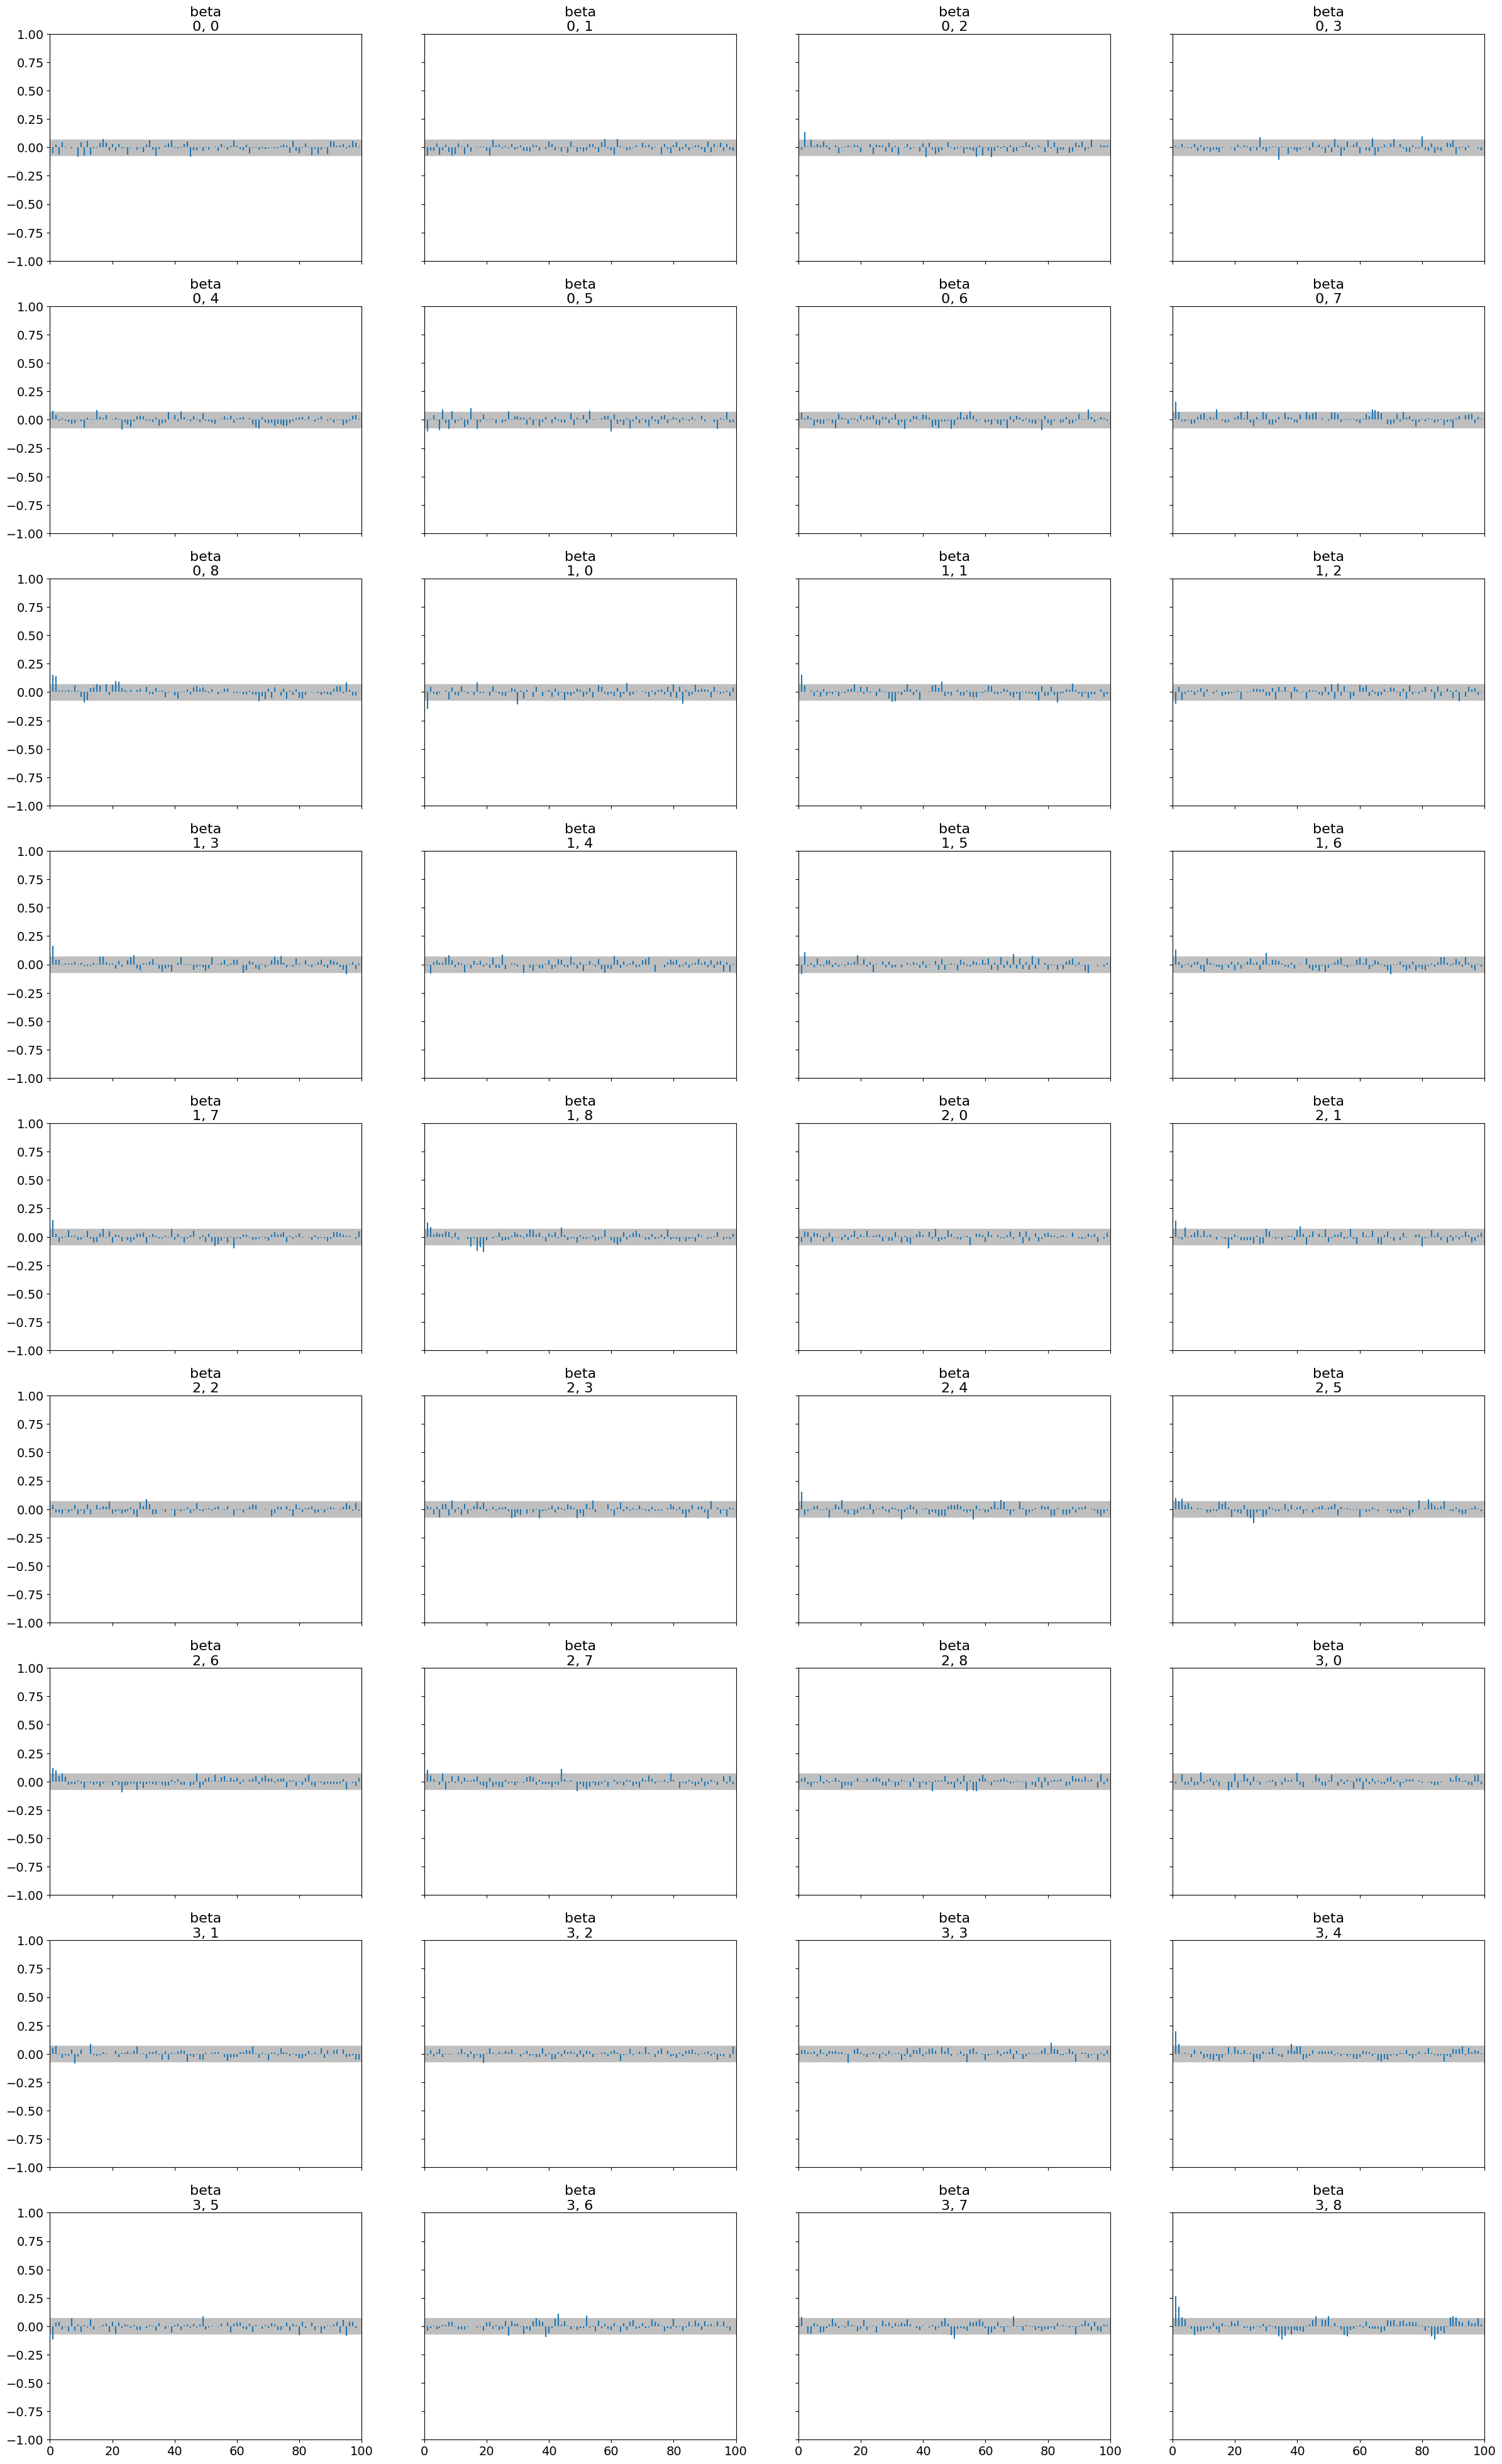

In [24]:
az.plot_autocorr(time_varying_idata, var_names=["beta"])

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'beta\n8'}>]], dtype=object)

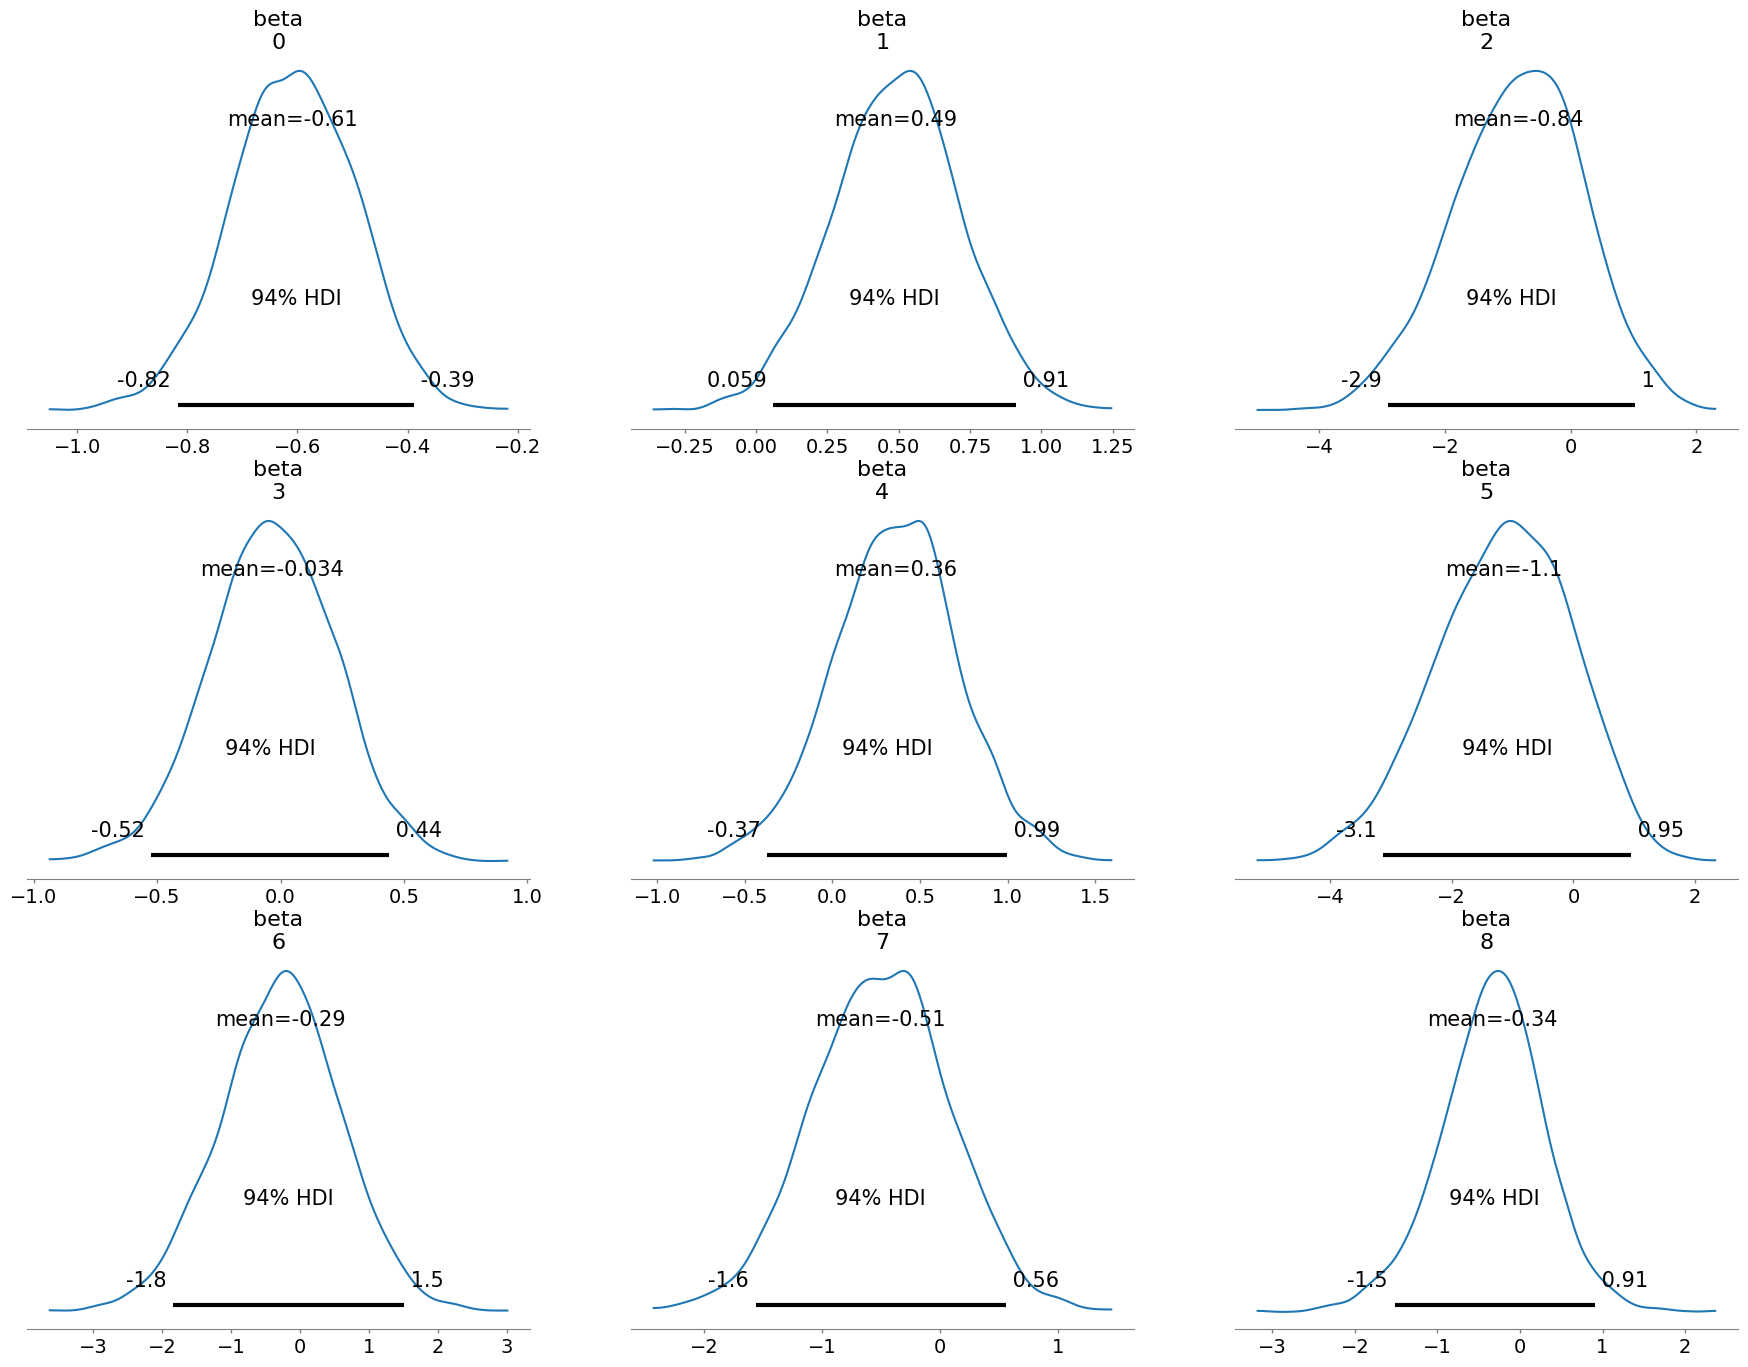

In [25]:
az.plot_posterior(time_varying_idata, var_names=["beta"])

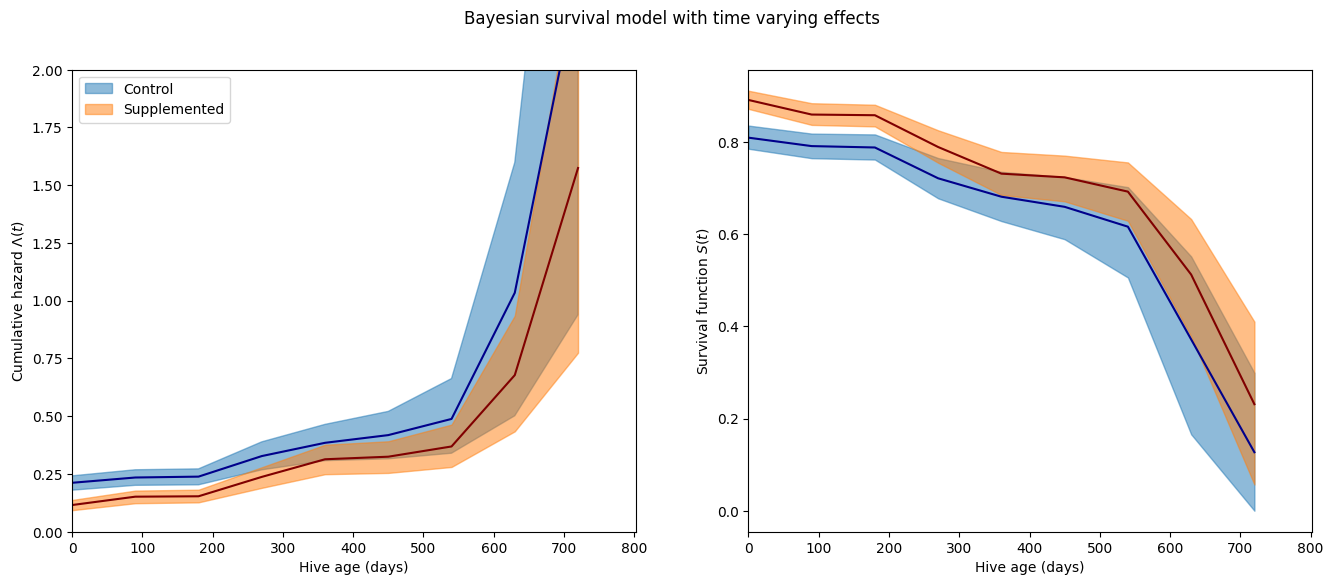

In [26]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_base_hazard),
    ax=hazard_ax,
    color="C0",
    smooth=False,
    fill_kwargs={"label": "Control"},
)

az.plot_hdi(
    time_varying_interval_bounds[:-1],
    cum_hazard(tv_met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Supplemented"},
)

hazard_ax.plot(time_varying_interval_bounds[:-1], get_mean(cum_hazard(tv_base_hazard)), color="darkblue")
hazard_ax.plot(time_varying_interval_bounds[:-1], get_mean(cum_hazard(tv_met_hazard)), color="maroon")

hazard_ax.set_xlim(0, short.queen_age.max())
hazard_ax.set_xlabel("Hive age (days)")
hazard_ax.set_ylim(0, 2)
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(time_varying_interval_bounds[:-1], survival(tv_base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(time_varying_interval_bounds[:-1], survival(tv_met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(time_varying_interval_bounds[:-1], get_mean(survival(tv_base_hazard)), color="darkblue")
surv_ax.plot(time_varying_interval_bounds[:-1], get_mean(survival(tv_met_hazard)), color="maroon")

surv_ax.set_xlim(0, short.queen_age.max())
surv_ax.set_xlabel("Hive age (days)")
surv_ax.set_ylabel("Survival function $S(t)$")
fig.suptitle("Bayesian survival model with time varying effects");

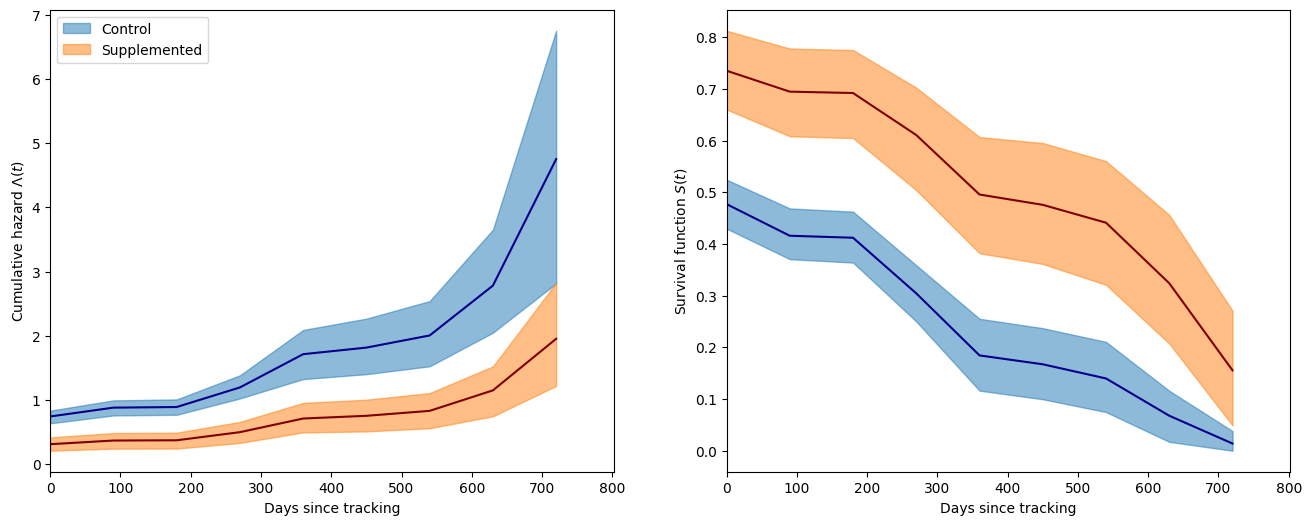

In [27]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Control"},
)
az.plot_hdi(
    interval_bounds[:-1],
    cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Supplemented"},
)

hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(base_hazard)), color="darkblue")
hazard_ax.plot(interval_bounds[:-1], get_mean(cum_hazard(met_hazard)), color="maroon")

hazard_ax.set_xlim(0, short.queen_age.max())
hazard_ax.set_xlabel("Days since tracking")
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2)

az.plot_hdi(interval_bounds[:-1], survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(interval_bounds[:-1], survival(met_hazard), ax=surv_ax, smooth=False, color="C1")

surv_ax.plot(interval_bounds[:-1], get_mean(survival(base_hazard)), color="darkblue")
surv_ax.plot(interval_bounds[:-1], get_mean(survival(met_hazard)), color="maroon")

surv_ax.set_xlim(0, short.queen_age.max())
surv_ax.set_xlabel("Days since tracking")
surv_ax.set_ylabel("Survival function $S(t)$")

plt.savefig("cox_ph_queen_survival.png")